# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** Jelena Banjac, Darko Lukic
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

In [1]:
import tarfile
import os
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from skimage import transform
from skimage.measure import find_contours
from numpy.fft import fft
from mpl_toolkits import mplot3d
import cv2
import scipy
from scipy.misc import imread
import random
from time import time
from sklearn.linear_model import LogisticRegression
from skimage.morphology import skeletonize
from difflib import SequenceMatcher
from itertools import product
from scipy.ndimage import shift
from scipy.optimize import minimize, differential_evolution
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [3]:
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

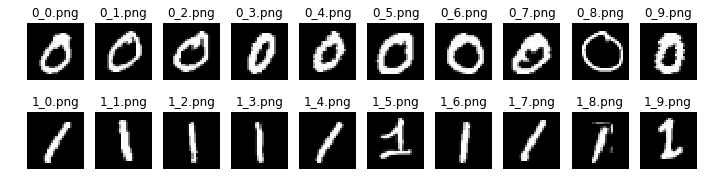

In [4]:
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'

#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)

#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

First, we obtain contours using marching squares (`skimage.measure.find_contours`) and map each point of the contours as $ u_i = x_i + j y_i $. Then Fourier descriptors are calculated by appying Fourier transformation on $ u_i $. Since, the first few elements of Fourier transformation capture majority of the shapes we continue working with them. 

Translation affects only the first element ($ f_0 $), therefore we don't use it for classification. Rotation $ e^{j\theta} $ will be part of each element ($ u_i' = u_i e^{j\theta} => f_l' = f_i e^{j\theta} $ ), so we take only an amplitude in order to make our classification invariant to rotation. And to make the our classificatio invariant to scaling we devide each element by $ f_1 $ to keep the ratio.

We have tried to use 1, 2 and 3 Fourirer descriptors to classify ones and zeros, but already with 2 Fourirer descriptors we got the perfect classification. Support Vector Machine is used to separate ones and zeros, but any other classification method can be applied.

In [5]:
def rotation(angle):
    """2D rotation matrix. Suprised it is not included in numpy
    
    Parameters
    ----------
    angle: Rotation angle
    
    Return
    ------
    2D Rotaion matrix
    """
    return np.matrix([
        [ np.cos(angle), -np.sin(angle) ],
        [ np.sin(angle), np.cos(angle) ]
    ])

def make_meshgrid(x, y, h=.02, padding=0.1):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - padding, x.max() + padding
    y_min, y_max = y.min() - padding, y.max() + padding
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def get_contours(im):
    """ Get the coordinates of contours, as shown in the image
    
    Parameters
    ----------
    im: ndarray image
        Image from which to find the contour
        
    Returns
    -------
    cont[0]: 2D array
        Coordinates of the contour
    """
    cont = find_contours(im, 0)
    cont[0] = (rotation(0) * cont[0].T).T
    cont[0] = np.flip(cont[0], 1)
    return cont[0]


def augment_images(images, n, rotation=True, rescale=True, brightness=True):
    """ Augment images
    
    Parameters
    ----------
    images: array
        Array of images
    n: int
        How many output images
    rotation: bool
        Rotation of an image will be performed if True
    rescale: bool
        Rescale an image if True
    brightness: bool
        Change the brightness of an image if True
    
    Returns
    -------
    out: array
        Augmented images        
    """
    out = []
    for i in range(n):
        img_index = np.random.randint(0, len(images) - 1)
        img = images[img_index]
        
        if rotation:
            img = transform.rotate(img, np.random.uniform(0, 30))
        if rescale:
            img = transform.rescale(img, np.random.uniform(0.9, 1.1), clip=False, mode='edge', multichannel=False)
        if brightness:
            img *= np.random.uniform(0.9, 1.1)
            img[img > 1] = 1
        out.append(img)
    return out

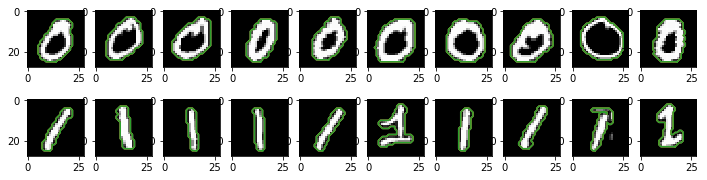

In [6]:
fig, ax = plt.subplots(2, len(zeros_im), figsize=(12, 3))

# Original image
X_data = np.concatenate((zeros_im, ones_im))
y_data = np.array([0]*len(zeros_im) + [1]*len(ones_im))


fd_inv = {}
for n_features in range(1, 4):
    fd_inv[n_features] = np.zeros((len(X_data), n_features))
    
    for i, (X, y) in enumerate(zip(X_data, y_data)):
        # Contours
        cont = get_contours(X)
        ax[i // 10, i % 10].imshow(X, cmap='gray')
        ax[i // 10, i % 10].plot(cont[:, 0], cont[:, 1])

        # DFT
        sing_cont = [ np.complex(n[0, 0], n[0, 1]) for n in cont ]
        fd = fft(sing_cont)
        fd_ref = abs(fd[1])
        for j in range(n_features):
            fd_inv[n_features][i, j] = abs(fd[j + 2]) / fd_ref

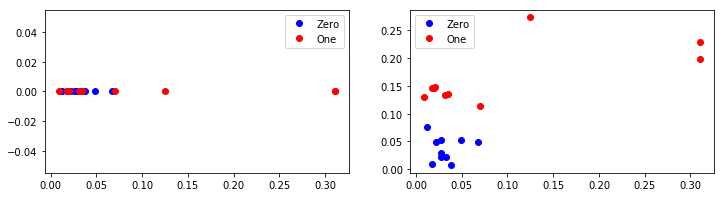

In [7]:
# Plot only a single and two features
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot(fd_inv[1][y_data == 0, 0], [0]*np.sum(y_data == 0), marker='o', lw=0, color='blue', label='Zero')
ax[0].plot(fd_inv[1][y_data == 1, 0], [0]*np.sum(y_data == 1), marker='o', lw=0, color='red', label='One')
ax[0].legend()

ax[1].plot(fd_inv[2][y_data == 0, 0], fd_inv[2][y_data == 0, 1], marker='o', lw=0, color='blue', label='Zero')
ax[1].plot(fd_inv[2][y_data == 1, 0], fd_inv[2][y_data == 1, 1], marker='o', lw=0, color='red', label='One')
ax[1].legend()

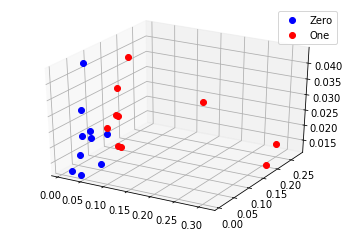

In [8]:
# Let's try what is happening to 3 features
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(fd_inv[3][y_data == 0, 0], fd_inv[3][y_data == 0, 1], fd_inv[3][y_data == 0, 2], marker='o', lw=0, color='blue', label='Zero')
ax.plot(fd_inv[3][y_data == 1, 0], fd_inv[3][y_data == 1, 1], fd_inv[3][y_data == 0, 2], marker='o', lw=0, color='red', label='One')
ax.legend()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0.5, 1.0, 'Accuracy 1.0')

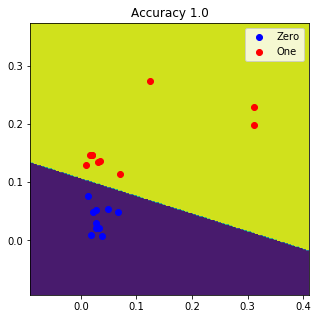

In [9]:
fd_inv_2d = fd_inv[2]
X_train, X_test, y_train, y_test = train_test_split(fd_inv_2d, y_data, test_size=0.2)

clf = svm.LinearSVC(C=1000)
clf.fit(X_train, y_train)
res = clf.score(X_test, y_test)

# Visualise
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
X0, X1 = fd_inv_2d[:, 0], fd_inv_2d[:, 1]
xx, yy = make_meshgrid(X0, X1, h=0.002)
plot_contours(ax, clf, xx, yy)

ax.plot(fd_inv_2d[y_data == 0, 0], fd_inv_2d[y_data == 0, 1], marker='o', lw=0, color='blue', label='Zero')
ax.plot(fd_inv_2d[y_data == 1, 0], fd_inv_2d[y_data == 1, 1], marker='o', lw=0, color='red', label='One')
ax.legend()
ax.set_title(f'Accuracy {res}')

---

### 1.3 Additional method(s)
Add your implementation and discussion

#### 1.3.1. Supervised Learning

In the one of the additional methods, we implement the supervised learning method called logistic regression. We found it interesting to implement since the logistic regression is usually used to predict the values in a setting that is similar to our.  

Our logistic regression model would need to predict whether the image contains 1 (1) or contains 0 (0). In order to train our model, we split our initial data into test and train datasets of the sizes 20%/80% respectivelly. Afterwars, we train our logistic regression model with the training data. After the model is trained, we then use it to predict the values from the test subset of images. The code implementation could be seen bellow.

In the end we can see that this classification is done with a high level of accuracy.

In [10]:
X_data_reshaped = np.concatenate([zeros_im, ones_im]).reshape(20, 784)
print(X_data_reshaped.shape)
y_data_reshaped = np.concatenate([np.zeros(len(zeros_im)), np.ones(len(ones_im))])
print(y_data_reshaped.shape)
X_train, X_test, y_train, y_test = train_test_split(X_data_reshaped, y_data_reshaped, test_size=0.2)

(20, 784)
(20,)


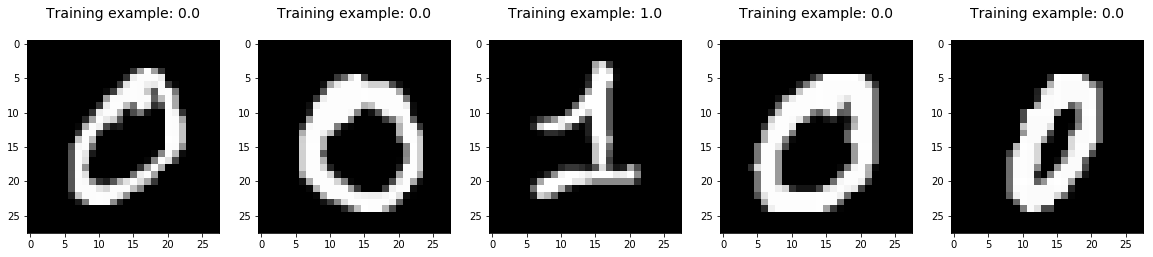

In [11]:
# Solution (Visualization)
%matplotlib inline

plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(X_train[5:10], y_train[5:10])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title(f'Training example: {label}\n', fontsize = 14)

The total time is 0.06469416618347168 seconds 
The classification accuracy is 1.0


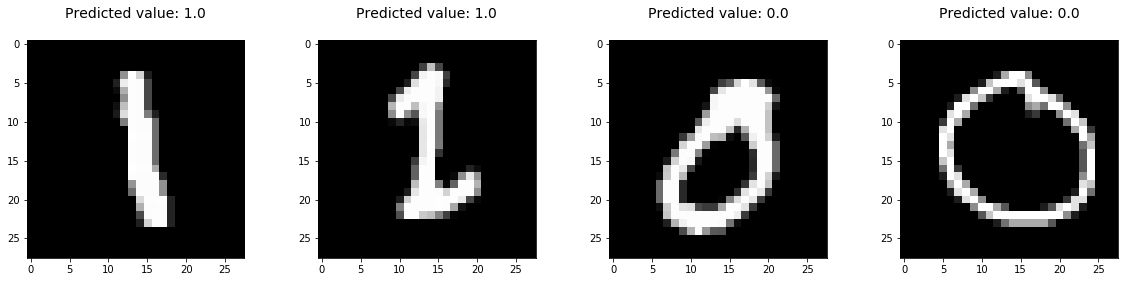

In [12]:
# Solution
%matplotlib inline

tic = time()

# Fit a linear regression model (using trX)
logistic_regr = LogisticRegression(solver='lbfgs')
logistic_regr.fit(X_train, y_train)


y_predicted = logistic_regr.predict(X_test)

plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(X_test, y_predicted)):
    plt.subplot(1, 4, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title(f'Predicted value: {label}\n', fontsize = 14)

# Compute the classification score
score = logistic_regr.score(X_test, y_test)

toc = time()

print(f'The total time is {toc-tic} seconds ')
print(f'The classification accuracy is {score}')

---

#### 1.3.2. Chain code

In this method, contours are encoded into strings and then an algorithm for word similarity measurement is used. 

We start by constructing a line between two neighbouring points. Then, we calculate an angle of the line with respect to the X-axis. The angle is scaled down to the desired range and rounded to the nearest integer. The procedure is repeated for all of the neighbouring points.

In the end, we have all images encoded into words. To detect a number from an image we compare word of the corresponding number to all other words. We consider the number is equal to zero if an average of similarity between a word of zero and tested word is smaller. Otherwise, it considers it as one.

The desired length of all words and the number of encoded directions is configurable. Therefore, we performed a few tests. We discovered that as the accuracy is increased with a higher number of angles (e.g. 20). Since the dataset is small we probably overfit it the model, so smaller number of angles (e.g. 8) should probably be better in general.

Moreover, we tried to change the number of characters in words. Here we discovered that we get the best result if we keep a number of characters about the same for all words. Also, more characters we used better results we got, but again, we probably caused overfitting of the model.

In [13]:
n_directions = 8
desired_length = 10

X_data_aug = augment_images(zeros_im, 30) + augment_images(ones_im, 30)
y_data_aug = [0]*30 + [1]* 30

X_encoded = []
y_encoded = [] 

for i, (X, y) in enumerate(zip(X_data_aug, y_data_aug)):
    # Get contours
    cont = get_contours(X)

    # Encode
    skip = int(len(cont) / desired_length)
    encoded = ''
    for i in range(0, len(cont) - skip, skip):
        p0 = cont[i].A1
        p1 = cont[i+skip].A1
        angle = np.arctan2(p1[1] - p0[1], p1[0] - p0[0])
        code = int(round(((angle + np.pi) * n_directions) / (2*np.pi), 0))
        encoded += str(chr(code+65))

    print(f'{y}[{i}]={encoded}\t', end='')

    X_encoded.append(encoded)
    y_encoded.append(y)

0[60]=ABCCDEEFGGH	0[60]=BCCDDEFGGHI	0[54]=BCCCDEFGGH	0[54]=ICCDDDFFGH	0[54]=ICCDDEFGHH	0[54]=IBCDDEFGHH	0[54]=BCCDDFFGGH	0[60]=HIIBCCDEFFG	0[54]=BBCCEFFGGH	0[60]=BCCDDEGFGHH	0[60]=ABBCDEFFGHH	0[54]=IBCDDEFGGH	0[56]=BCDDEFGHH	0[63]=BCCDDEGGHH	0[60]=BCCCDEFFGHH	0[60]=BCCCDEFGGHH	0[54]=ACCCDEFGGH	0[63]=ABCDDEFGGH	0[54]=HIABCCDEEF	0[60]=IBCDCEEGGGH	0[60]=IBCDDDFGGHH	0[54]=ACCCDEFGGG	0[72]=BCCDEEGGHI	0[60]=BBCCDEFFGHI	0[54]=ABCDDEFGGH	0[63]=IBBCDEFFHH	0[63]=BBCDEEFGHH	0[54]=ABCCDEFFGH	0[54]=ACCCDEFGGG	0[54]=BCCDEFGGGH	1[63]=BCCBEFGFIH	1[63]=BCCADEFFGH	1[50]=BCBCCEFGGGH	1[63]=BCCBDEGFGH	1[50]=BCCCCEGGGGH	1[45]=BCCCCEGGGG	1[45]=BBBBDEGFGG	1[50]=ACCDCDFGHGG	1[63]=BCCBDFGFHG	1[81]=CDIDDFGFIH	1[60]=BCCBDEFHFIG	1[45]=ACCCCEGGFG	1[45]=ACCBCEGGGG	1[72]=BDBBDDFGFI	1[45]=GGGGHBCCCC	1[45]=ACCCDEFGFG	1[45]=ACCBCEFGFG	1[72]=BDBBDDFGFH	1[63]=BCCBEFGFHH	1[48]=ACCCDEGGH	1[63]=BCCADEGFHG	1[45]=BCBBCEFGGG	1[50]=BCCCCEFGGGG	1[50]=ACCDCDFGGHG	1[50]=ABCDCDEGHHG	1[72]=CDHCCEGFGH	1[54]=BCCCDFGGGH	1[50]=ACCCCEFFGG

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


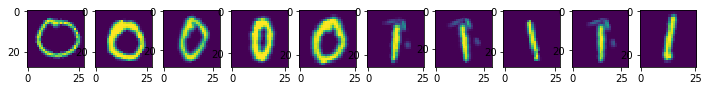

In [14]:
fig, ax = plt.subplots(1, 10, figsize=(12, 3))

for index, (image, label) in enumerate(zip(X_data_aug[25:35], y_data_aug[25:35])):
    ax[index].imshow(image)

In [15]:
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X_encoded, y_encoded, test_size=0.2)

corr = 0
for X_test, y_test in zip(X_data_test, y_data_test):
    cumulative_similarity = [0, 0]
    
    for X_train, y_train in zip(X_data_train, y_data_train):
        s = SequenceMatcher(None, X_train, X_test)
        cumulative_similarity[y_test] += s.ratio()
    detected = 0 if cumulative_similarity[0] > cumulative_similarity[1] else 1
    
    corr += (y_test == detected)
    print(f'Expected {y_test} got {detected}')
    
print(f'Accuracy {round(corr / len(X_data_test), 2)}')

Expected 1 got 1
Expected 0 got 0
Expected 0 got 0
Expected 1 got 1
Expected 0 got 0
Expected 0 got 0
Expected 1 got 1
Expected 1 got 1
Expected 0 got 0
Expected 1 got 1
Expected 0 got 0
Expected 1 got 1
Accuracy 1.0


---

#### 1.3.3. Distance between two contours

Here we have implemented classification of ones and zeros by calculating a distance between two contours. The algorithm have the following characteristics:
- Simplifications
    - Distance map
    - Chamfer distance
- Transformations
    - Rotation
    - Translation
- Minimisation algorithms
    - Powel or
    - Genetic Algorithm
    
First we create a distance map for a few reference images. In order to speed up calculation of the distance map Chamfer distance is applied. Then, we search for minimal distance between tested and reference images by applying different transformations, rotation and translation. The result is corresponding number of reference image with the lowest distance.

Potential improvements. We discovered a lot of space for improvements. Our algorithm is limited on only two transformations, rotation and translation. By additing more transformations, e.g. skew or scalling, the algorithm would become more robust. In addition, computational cost depends a lot on optimisation methods, therefore we have experimented with a few. Non of the used algorithms supports definition of step size, as we don't need subpixel precision increasing step size to >=1px would significantly increase computational speed.

Overall, even with all improvements it would still be computationaly very expensive as the distance has to be calculated many times. However, it is very fun to experiment with for beginners.

In [16]:
def check_bounds(matrix, pixel):
    """Simple function to check if coordinates of `pixel` are in the bounds of `matrix`
    """
    return pixel[0] >= 0 and pixel[1] >= 0 and \
        pixel[0] < matrix.shape[0] and pixel[1] < matrix.shape[1]


def distance_map(im):
    """Creates a distance map
    
    The algorithm starts from top left corner. For each pixel it finds it's neighboors 
    and calculates Chamfer distance. If distance is less than already written distance,
    distance is is alternated. The second pass starts from bottom right corner and the
    same algorithm repeats.
    
    Parameters
    ----------
    im: Binary image
    
    Returns
    -------
    distance_matrix: Distance map
    """
    visited = np.zeros(im.shape)
    distance_matrix = np.ones(im.shape) * np.inf
    distance_matrix[im > 230] = 0
    
    moves = np.matrix([[0, 1], [0, -1], [-1, 0], [1, 0], [1, 1], [-1, -1], [1, -1], [-1, 1]])
    costs = np.array([3, 3, 3, 3, 4, 4, 4, 4])
    
    products = [ 
        product(range(im.shape[0]), range(2*im.shape[1])),
        product(range(im.shape[0], 0, -1), range(2*im.shape[1], 0, -1))
    ]
    
    for product_i in products:
        for i, j_tmp in product_i:
            j = j_tmp - i
            
            current_pixel = np.array([i, j])
            for move, cost in zip(moves, costs):
                neighboor = tuple(current_pixel + move.A1)
                if check_bounds(im, current_pixel) and check_bounds(im, neighboor):
                    neighboor_cost = distance_matrix[tuple(current_pixel)] + cost
                    if distance_matrix[neighboor] > neighboor_cost:
                        distance_matrix[neighboor] = neighboor_cost

    return distance_matrix


def ls_func(params, distance_map, x):
    """Callback function used in minimisation algorithm
    """
    rotation = params[0]
    translation = (params[1], params[2])
    ref_image = transform.rotate(distance_map, rotation, cval=np.max(distance_map))
    ref_image = shift(ref_image, translation, cval=np.max(distance_map))
    fitness = np.sum(ref_image[x > 220]) * np.sum(distance_map == 0)
    return fitness




Text(0.5, 1.0, 'Distance map of 1')

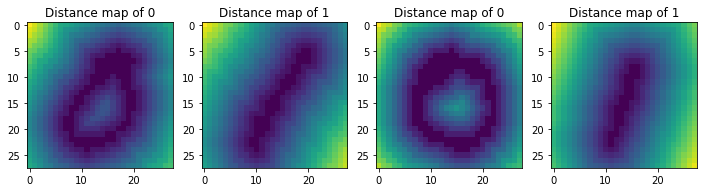

In [17]:
# Create distance map for reference images
distance_maps = [
    [ distance_map(X_data[y_data == 0][0]), distance_map(X_data[y_data == 0][6]) ],
    [ distance_map(X_data[y_data == 1][0]), distance_map(X_data[y_data == 1][8]) ]
]

fig, ax = plt.subplots(1, 4, figsize=(12, 5))
ax[0].imshow(distance_maps[0][0])
ax[0].set_title('Distance map of 0')
ax[1].imshow(distance_maps[1][0])
ax[1].set_title('Distance map of 1')
ax[2].imshow(distance_maps[0][1])
ax[2].set_title('Distance map of 0')
ax[3].imshow(distance_maps[1][1])
ax[3].set_title('Distance map of 1')

In [18]:
x0 = [0, 0, 0]
bounds = [(-20, 20), (-3, 3), (-3, 3)]

correct = 0
for i, (X, y) in enumerate(zip(X_data, y_data)):
    res_min = [np.inf, np.inf]
    
    for dist_number in range(len(distance_maps)):
        for dist_map in distance_maps[dist_number]:
            res = minimize(ls_func, x0, args=(dist_map, X), method='Powell')
            #res = differential_evolution(ls_func, bounds, args=(dist_map_0, im), maxiter=1)
            if res.fun < res_min[dist_number]:
                res_min[dist_number] = res.fun
                
    detected = 1 if res_min[1] < res_min[0] else 0
    correct += detected == y
    # print(f'Expected {y} detected {detected}')
    
print(f'Accuracy {correct / len(X_data)}')

Accuracy 1.0


---

#### 1.3.4. Morphological Skeleton

In this additional method, we implemented morphological skeleton image and used it as an input to a distance map instead of the input we had in the previous additional method.   

In one of the following cells, you are able to see how does skeleton looks for every image from the given dataset. Afterwards, we use distance map from the previous part, to predict what will be the content of the image.

General benefits of this method are that in many computer vision applications we often have to deal with huge amounts of data: processing can therefore be slow and requires a lot of memory. In order to achieve faster processing and a smaller memory footprint, this morphological skeleton method represents one very compact one. 

In our case we shrinked the image until the area of interest is 1 pixel wide. 

In [19]:
def get_morphological_skeleton(image):
    """ Create a morphological skeleton from an image
    
    Parameters
    ----------
    image: array 2D
        Input image
    
    Returns
    -------
    skeleton: array 2D
        Image containing the skeleton of an input image. It only has 2 distinct values, 0 and 255.
    """
    # binarize image
    ret,image = cv2.threshold(image,127,255,0)
    
    # make True/False if the pixel is equal to 255
    image = image==255

    # perform skeletonization
    skeleton = skeletonize(image)
    
    # put values in 0 and 255 instead of 0 and 1
    return skeleton*255

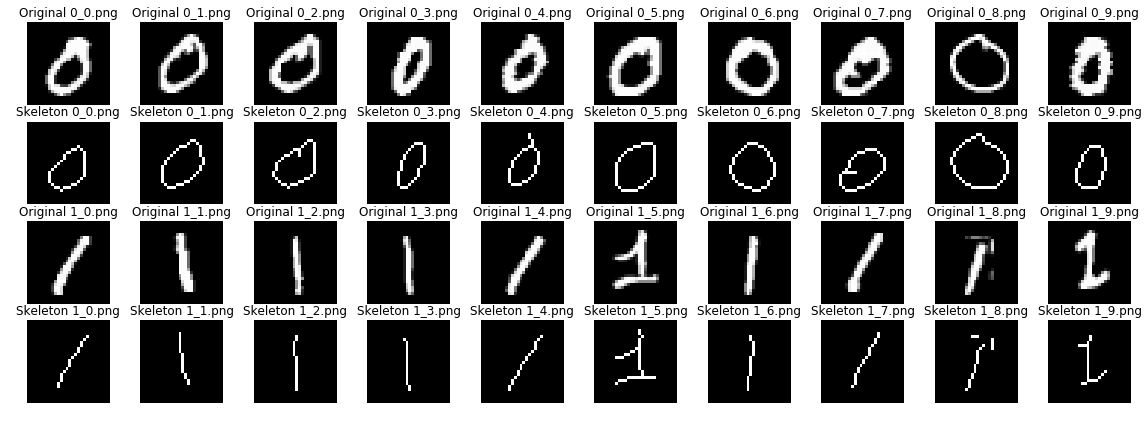

In [20]:
# Plot images
fig, axes = plt.subplots(4, len(zeros_im), figsize=(20, 7))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Original {nm}")
for ax, im, nm in zip(axes[1], zeros_im, zeros_names):
    ax.imshow(get_morphological_skeleton(im), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Skeleton {nm}")
for ax, im, nm in zip(axes[2], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Original {nm}")
for ax, im, nm in zip(axes[3], ones_im, ones_names):
    ax.imshow(get_morphological_skeleton(im), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Skeleton {nm}")

Text(0.5, 1.0, 'Distance map of 1')

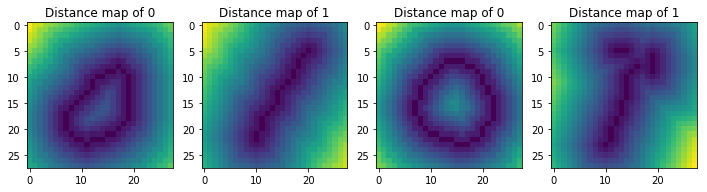

In [21]:
# Create distance map for reference images
distance_maps = [
    [ distance_map(get_morphological_skeleton(X_data[y_data == 0][0])), distance_map(get_morphological_skeleton(X_data[y_data == 0][6])) ],
    [ distance_map(get_morphological_skeleton(X_data[y_data == 1][0])), distance_map(get_morphological_skeleton(X_data[y_data == 1][8])) ]
]

fig, ax = plt.subplots(1, 4, figsize=(12, 5))
ax[0].imshow(distance_maps[0][0])
ax[0].set_title('Distance map of 0')
ax[1].imshow(distance_maps[1][0])
ax[1].set_title('Distance map of 1')
ax[2].imshow(distance_maps[0][1])
ax[2].set_title('Distance map of 0')
ax[3].imshow(distance_maps[1][1])
ax[3].set_title('Distance map of 1')

In [22]:
x0 = [0, 0, 0]
bounds = [(-20, 20), (-3, 3), (-3, 3)]

correct = 0
for i, (X, y) in enumerate(zip(X_data, y_data)):
    res_min = [np.inf, np.inf]
    
    for dist_number in range(len(distance_maps)):
        for dist_map in distance_maps[dist_number]:
            res = minimize(ls_func, x0, args=(dist_map, X), method='Powell')
            #res = differential_evolution(ls_func, bounds, args=(dist_map_0, im), maxiter=1)
            if res.fun < res_min[dist_number]:
                res_min[dist_number] = res.fun
                
    detected = 1 if res_min[1] < res_min[0] else 0
    correct += detected == y
    # print(f'Expected {y} detected {detected}')
    
print(f'Accuracy {correct / len(X_data)}')

Accuracy 1.0


---

#### 1.3.5. Curve Polygonalisation

In this additional method, we will see how in series of steps we can find different contours representing one object of the image. Specifying the degree of the polynome used to approximate the curve will affect the look of the contour of the object. In the following code we will see one image where `find_contouts` was used. There we have dots that represent a contour and have an approximatelly equal distance from each other on the contour. In the next step we use `subdivide_polygon` which represents a subdivision of polygonal curves using B-Splines. We run it with degree 2. The last step we use is call `approximate_polygon` which approximates a polygonal chain with the specified tolerance. We can notise that dots of the contour are concentrated in the curvatures of the curve.

In [23]:
# subdivide polygon using 2nd degree B-Splines
img = ones_im[2]
cont = find_contours(img, 0)[0]

cont_img = np.zeros(img.shape)
for c in cont:
    cont_img[tuple(map(int,c))] = 255

new_cont= cont.copy()
for _ in range(5):
    new_cont = subdivide_polygon(new_cont, degree=2, preserve_ends=True)

new_cont_img = np.zeros(img.shape)
for c in new_cont:
    new_cont_img[tuple(map(int,c))] = 255

#new_cont= cont.copy()
# approximate subdivided polygon with Douglas-Peucker algorithm
appr_cont = approximate_polygon(new_cont, tolerance=0.02)

appr_cont_img = np.zeros(img.shape)
for c in appr_cont:
    appr_cont_img[tuple(map(int,c))] = 255

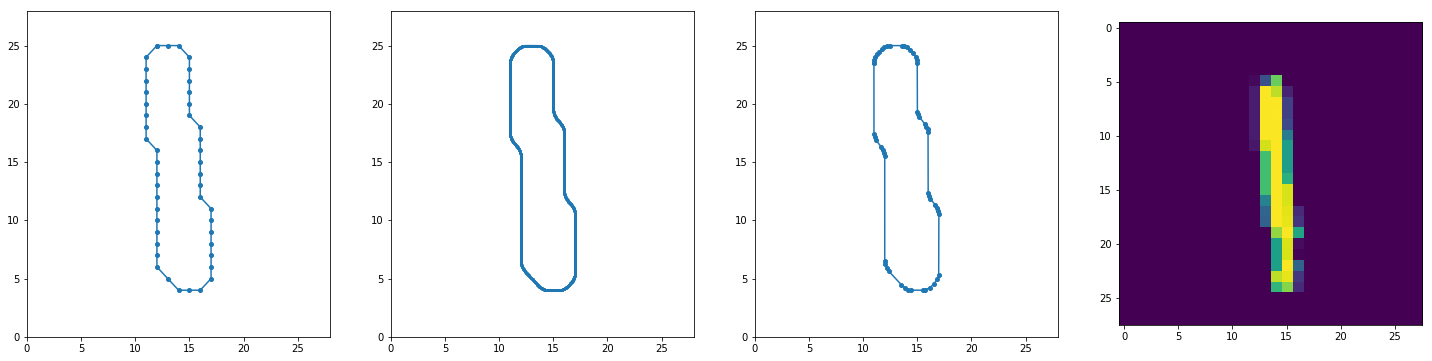

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(25,6))
ax1.set_xlim((0,28))
ax1.set_ylim((0,28))
ax2.set_xlim((0,28))
ax2.set_ylim((0,28))
ax3.set_xlim((0,28))
ax3.set_ylim((0,28))

ax1.plot(28-cont[:, 1],cont[:, 0], marker='o', markersize=4)
ax2.plot(28-new_cont[:, 1], new_cont[:, 0], marker='o', markersize=2)
ax3.plot(28-appr_cont[:, 1],appr_cont[:, 0], marker='o', markersize=4)

ax4.imshow(img)

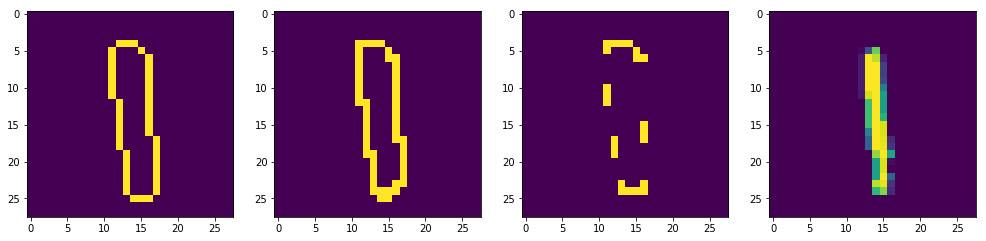

In [25]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(17,5))

ax1.imshow(cont_img)
ax2.imshow(new_cont_img)
ax3.imshow(appr_cont_img)

ax4.imshow(img)

Now, let's put the code from above to the definition. The rest is used from the Chain code.

In [26]:
def get_approximate_polygone(img):
    """Create an approximate polygone
    
    Parameters
    ----------
    img: array 2D
        Input image
    
    Returns
    -------
    appr_cont: array
        The coordinates of the approximated contour.
    """
    # subdivide polygon using 2nd degree B-Splines
    cont = find_contours(img, 0)[0]

    new_cont= cont.copy()
    for _ in range(5):
        new_cont = subdivide_polygon(new_cont, degree=2, preserve_ends=True)

    # approximate subdivided polygon with Douglas-Peucker algorithm
    appr_cont = approximate_polygon(new_cont, tolerance=0.02)

    return appr_cont

In [27]:
def get_contours(im):
     """ Get the coordinates of contours, as shown in the image
    
    Parameters
    ----------
    im: ndarray image
        Image from which to find the contour
        
    Returns
    -------
    cont: 2D array
        Coordinates of the contour
    """
    cont = get_approximate_polygone(im)
    cont = (rotation(0) * cont.T).T
    cont = np.flip(cont, 1)
    return cont

In [28]:
n_directions = 8
desired_length = 10

X_data_aug = augment_images(zeros_im, 30) + augment_images(ones_im, 30)
y_data_aug = [0]*30 + [1]* 30

X_encoded = []
y_encoded = [] 

for i, (X, y) in enumerate(zip(X_data_aug, y_data_aug)):
    # Get contours
    cont = get_contours(X)

    # Encode
    skip = int(len(cont) / desired_length)
    encoded = ''
    for i in range(0, len(cont) - skip, skip):
        p0 = cont[i].A1
        p1 = cont[i+skip].A1
        angle = np.arctan2(p1[1] - p0[1], p1[0] - p0[0])
        code = int(round(((angle + np.pi) * n_directions) / (2*np.pi), 0))
        encoded += str(chr(code+65))

    print(f'{y}[{i}]={encoded}\t', end='')

    X_encoded.append(encoded)
    y_encoded.append(y)

0[126]=ABCDDEFGGH	0[126]=ABCCDEFGGH	0[99]=IBCDEEFGGH	0[108]=ABCDDEGGHH	0[99]=BDCEFFGHHH	0[108]=ACDDDEGGHH	0[99]=ICCCDDEGHH	0[108]=ACCDCEFGHH	0[117]=ACCCDEFGGH	0[135]=ABCDDEFFGH	0[117]=ABCCCDDFGH	0[117]=BCDDDFGGGH	0[144]=ABCCDEFGHH	0[99]=ACDCDEFGHH	0[99]=ACDDEGFHHH	0[90]=IBCCDDEGGH	0[108]=ACCCDEFGGH	0[117]=BCCDEFFGHH	0[126]=BCCCDFFGHH	0[99]=ICCCDDEGHH	0[108]=IBCCDEEGGI	0[144]=BCCDEFFGHH	0[90]=ICCDEFGGHH	0[117]=ACDDFFGHHH	0[108]=ACDDEFGGHH	0[117]=ABCCDFFFGH	0[135]=ABCCDEEFGH	0[90]=IBCDDEFGGH	0[117]=GFGHHIBCCD	0[99]=IBCDDDFGGH	1[54]=HACBCCDEFG	1[81]=ICDCCEGHHG	1[81]=ACCCCEFGGF	1[96]=ABBCDFFFF	1[108]=ABBBCDFGFF	1[117]=ACCCCCDGGG	1[81]=ACCCDEGHHG	1[108]=ACCBDEGFGG	1[72]=ICBCCCDFGG	1[108]=ABBBCEFFFF	1[72]=ICCCCDFGGG	1[99]=ACCDCDFHGG	1[72]=IBCCDEGFGF	1[90]=ICCDCDFGHG	1[126]=BDBBDCFGFI	1[70]=IBCCCEEGGGH	1[99]=BCCBCEGFHH	1[81]=ACCCDEFGGG	1[126]=IDDACDEGFI	1[80]=FGGGHABCC	1[153]=ACBCDFGEGH	1[126]=ACCDDFGEGH	1[88]=ICCCEFGGG	1[90]=BCDCDEGHGG	1[54]=ICCBCDDFGF	1[48]=HBCEGHGGG	1[117]=ACCBDEGFHH	1[135

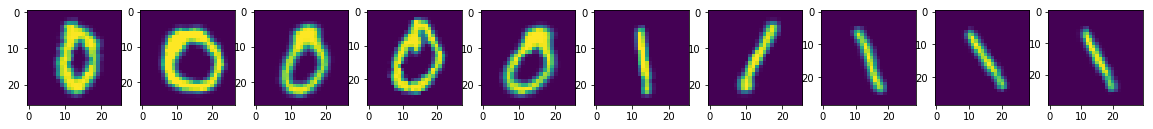

In [29]:
fig, ax = plt.subplots(1, 10, figsize=(20, 5))

for index, (image, label) in enumerate(zip(X_data_aug[25:35], y_data_aug[25:35])):
    ax[index].imshow(image)

In [30]:
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X_encoded, y_encoded, test_size=0.2)

corr = 0
for X_test, y_test in zip(X_data_test, y_data_test):
    cumulative_similarity = [0, 0]
    
    for X_train, y_train in zip(X_data_train, y_data_train):
        s = SequenceMatcher(None, X_train, X_test)
        cumulative_similarity[y_test] += s.ratio()
    detected = 0 if cumulative_similarity[0] > cumulative_similarity[1] else 1
    
    corr += (y_test == detected)
    print(f'Expected {y_test} got {detected}')
    
print(f'Accuracy {round(corr / len(X_data_test), 2)}')

Expected 1 got 1
Expected 0 got 0
Expected 0 got 0
Expected 1 got 1
Expected 1 got 1
Expected 0 got 0
Expected 1 got 1
Expected 1 got 1
Expected 0 got 0
Expected 1 got 1
Expected 0 got 0
Expected 0 got 0
Accuracy 1.0
